## Please Ignore All The Comments

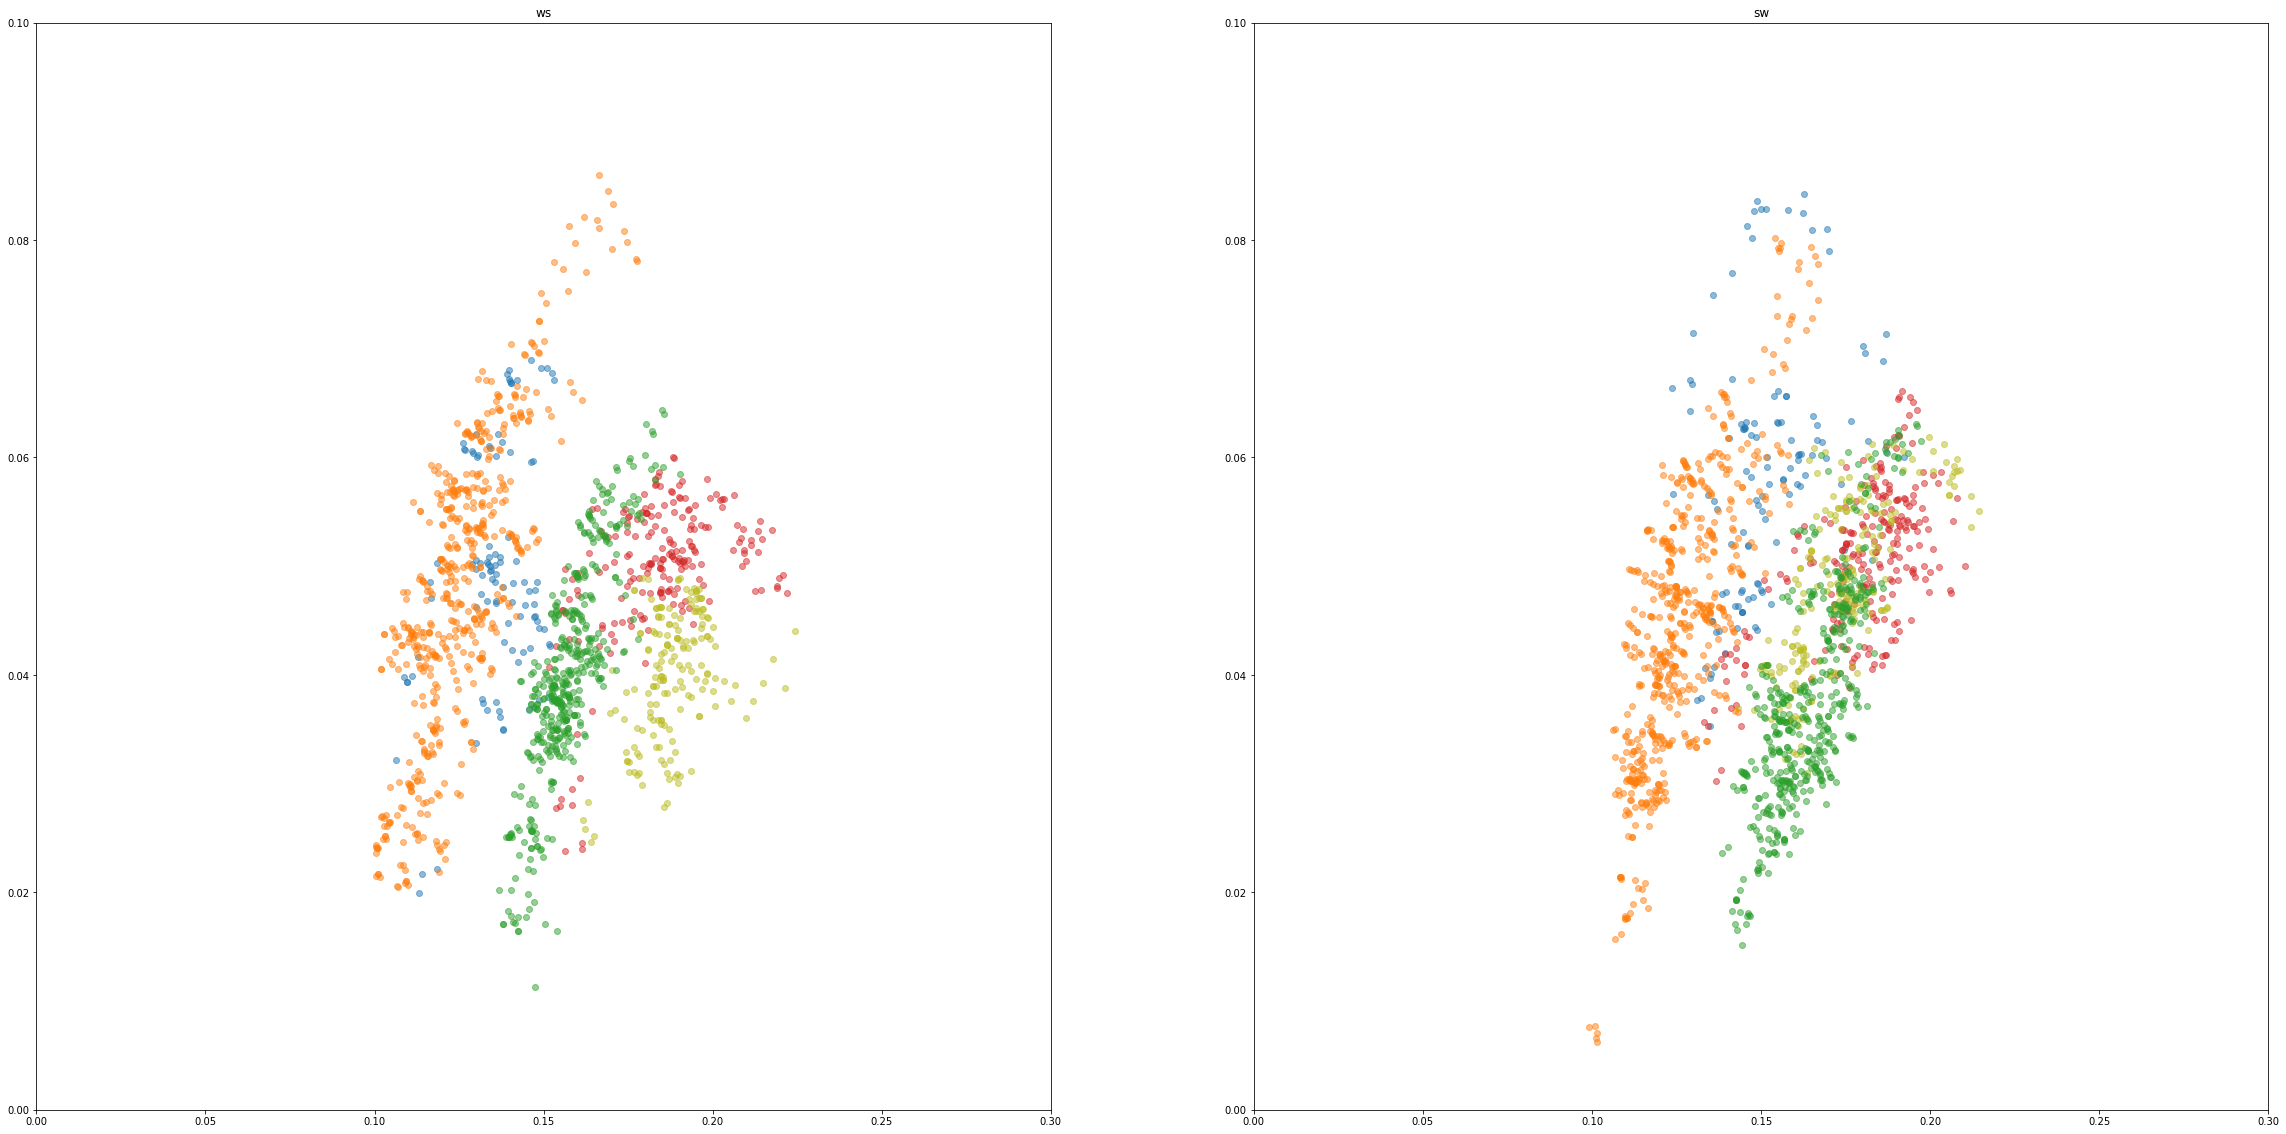

In [8]:
%matplotlib inline
from log_parser import parse_keyboard_log
from log_parser import extract_predefined_patterns
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from log_parser import parse_keyboard_log
from numpy_ringbuffer import RingBuffer

sample_size = 20
labels = ['HEN', 'ZIR', 'JOS', 'MAR', 'MIT'] # Left out Jon bc he has no SOL logfile
# Also I should just change this to use the routing file but it is what it is

# Creates 4 subplots
fig, ax = plt.subplots(1, 2, figsize=(40, 20))

predefined_patterns = {'w':['s','q','1'], 's':['w'], 'd':['f'], 'f':['d'], 'q':['a','w'], 'a':['q'], '1':['w']}
for name in labels: # For each name listed above:

    # Convert the logfile to a DataFrame
    kb = parse_keyboard_log(f"logs/{name}/SOL/key.log")


    # Temperory dictionaries used to stire the most recent press or release for keys in the predefined_patterns
    tempPressDict = {}
    tempReleaseDict = {}
    # The result dictionary used to store the average/highest/shortest duration for the key release-press pairs in the predefined_patterns
    # The result should have the following format:  'resultKey':[totalDuration, freq, longestDuration, shortestDuration, averageDuration]
    durations_dict = {}
    duration_data = {}
    #Find the key release-press pairs and calculate duration and freq for each pair, and re
    for _, row in kb.iterrows():
        # Extract keyname (remove surrounding '' if needed)
        key = row['key']
        key = key.replace("'", "")

        if key in predefined_patterns:
            # Get the time and the action for this row
            time = float(row['time'])
            action = row['action']

            if action == 'pressed': # if it is the press of a release-press pair
                # Update the time in tempPressDict
                tempPressDict[key] = time
                # Check for the release-press pair
                for pairedKey in predefined_patterns[key]:# check release-press pair for all paired keys for this key
                    if pairedKey in tempReleaseDict:# if we have the data for the required key release 
                        # Validate a release-press pair by 2 metrics: 1. press time < release time. 2. (press time - release time) < 0.3 second
                        if tempReleaseDict[pairedKey] < time and time - tempReleaseDict[pairedKey] <= 0.3:
                            curr_duration = time - tempReleaseDict[pairedKey]# calculate duration for this release-press pair
                            resultKey = key + pairedKey # compute resultKey
                            if resultKey in durations_dict:# if it's not the first record for resultKey
                                # update total duration and freq
                                durations_dict[resultKey].append(curr_duration)
                                durations_np = np.array(durations_dict[resultKey]) # Convert to numpy array
                                if durations_np.size > 3:
                                    duration_data[resultKey][0].append((durations_np.mean(), durations_np.std()))
                                    duration_data[resultKey][1].append('Hengjun')
                            else:# if it is the first record for resultKey
                                durations_dict[resultKey] = RingBuffer(capacity=sample_size, dtype=float)
                                duration_data[resultKey] = [[], []]
            else: # if it is the release of a release-press pair
                tempReleaseDict[key] = time # Update the time in tempReleaseDict

    # I got pretty lazy here but it works lol
    color = 'black'
    if name == 'HEN':
        color = 'tab:blue'
    if name == 'ZIR':
        color = 'tab:red'
    if name == 'JOS':
        color = 'tab:olive'
    if name == 'MAR':
        color = 'tab:green'
    if name == 'MIT':
        color = 'tab:orange'
    if name == 'JON':
        color = 'tab:purple'

    # Each call to scatter() on the same axes just draws more points on top of it
    ax[0].set_title('ws')
    ax[0].set_xlim(0, 0.30)
    ax[0].set_ylim(0.00, 0.10)
    ax[0].scatter([x for x, _ in duration_data['ws'][0]], [y for _, y in duration_data['ws'][0]], c=color, alpha=0.5)

    ax[1].set_title('sw')
    ax[1].set_xlim(0, 0.30)
    ax[1].set_ylim(0.00, 0.10)
    ax[1].scatter([x for x, _ in duration_data['sw'][0]], [y for _, y in duration_data['sw'][0]], c=color, alpha=0.5)